# Generator 可以使用 next 來進行循環中的一步
文字上有點難解釋，直接來看範例就能了解什麼是 Generator! <br />
<br />
## 撰寫一個 Generator，一次吐出 list 中的一個值

In [0]:
def output_from_list_generator(your_list):
    for i in your_list:
        yield i

In [0]:
my_list = [1,2,3,4,5]
gen = output_from_list_generator(my_list)

In [0]:
next(gen)

1

In [0]:
next(gen)

2

In [0]:
next(gen)

3

In [0]:
next(gen)

4

In [0]:
next(gen)

5

從上面的範例程式碼我們可以看到，當使用一次 next，generator 就會跑 for_loop 一次，因此得到 list 中的第一個值，當再使用一次後，for_loop 記得上次的循環，所以吐出第二個值。最後一次，因為 for loop 已經執行結束了，所以再使用 next 就會看到 StopIteration，無法在得到值
我們可以撰寫一個無限循環的 Generator，只要使用 While True 即可

In [0]:
def inf_loop_generator(your_list):
    while True:
        for i in your_list:
            yield i

In [0]:
inf_gen = inf_loop_generator(my_list)

In [0]:
next(inf_gen)

1

In [0]:
next(inf_gen)

2

In [0]:
next(inf_gen)

3

In [0]:
next(inf_gen)

4

In [0]:
next(inf_gen)

5

In [0]:
next(inf_gen)

1

In [0]:
next(inf_gen)

2

## 上面的程式碼因為我們使用了 While True，所以 for loop 不會結束，只要 call next 就一定會跑一次循環，並返回值

## 雖然 Cifar-10 的資料可以全部讀進記憶體，但讓我們試著用 Generator，批次的把 Cifar 10 的資料取出來，一次取 32 張出來！

In [0]:
from math import ceil
import matplotlib.pyplot as plt
import numpy as np

def img_combine(img, ncols = 8, size = 1, path = False):
    
    nimg = len(img)
    nrows = ceil(nimg/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize = (ncols*size, nrows*size))
    
    if nrows == 0:
        return
    idx = 0
    for row in range(nrows):
        for col in range(ncols):
            if(idx >= nimg):
                row = nrows
                break
                
            
            ax = axes[row,col]
            ax.imshow(img[idx], cmap = 'rainbow', vmin = 0, vmax = 1)
            ax.set_axis_off
            
            idx += 1
    plt.show()

In [0]:
from keras.datasets import cifar10
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

170500096/170498071 [==============================] - 9s 0us/step


In [0]:
def cifar_generator(image_arr, batch_size = 32):
    while True:
        for idx in range(0,  len(image_arr), batch_size):
            images = train_x[idx : idx + batch_size]
            labels = train_y[idx : idx + batch_size]
            
            yield images, labels

In [0]:
cifar_gen = cifar_generator(train_x)

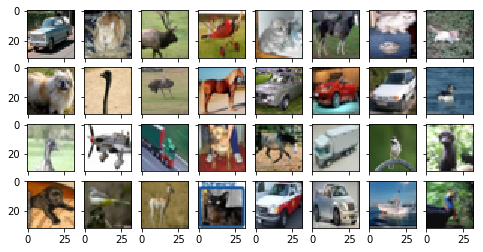

In [0]:
imgs, labels = next(cifar_gen)
img_combine(imgs)

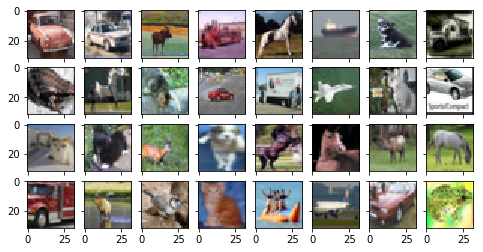

In [0]:
imgs, labels = next(cifar_gen)
img_combine(imgs)

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
import os

!nvidia-smi

Using TensorFlow backend.


Fri Aug  2 13:15:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    18W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
def preproc_x(x, flatten = True):
  x = x / 255.0
  if flatten:
    x = x.reshape((len(x),-1))
  return x

def preproc_y(y, num_classes = 10):
  if y.shape[-1] == 1:
    y = keras.utils.to_categorical(y,num_classes)
    
  return y

In [0]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x = preproc_x(train_x, False)
test_x = preproc_x(test_x, False)
train_y = preproc_y(train_y)
test_y = preproc_y(test_y)

print(f' train_x shape : {train_x.shape}')
print(f' train_y shape : {train_y.shape}')
print(f' test_x shape : {test_x.shape}')
print(f' test_y shape : {test_y.shape}')

 train_x shape : (50000, 32, 32, 3)
 train_y shape : (50000, 10)
 test_x shape : (10000, 32, 32, 3)
 test_y shape : (10000, 10)


In [0]:
def build_CNN(input_shape, output_units = 10):
  
  
  input_layer = keras.layers.Input(input_shape)
  
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(input_layer)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(units = 512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(units = 256)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(units = 128)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  output_layer = Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model( inputs = [input_layer], outputs = [output_layer])
  return model

In [0]:
image_gen = ImageDataGenerator( rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1 )



In [0]:
def cifar_gen(image_arr, batch_size = 128):
    while True:
        for idx in range(0,  len(image_arr), batch_size):
            images = train_x[idx : idx + batch_size]
            labels = train_y[idx : idx + batch_size]
            
            yield images, labels
                        
            
def make_cifar_aug_gen(input_gen):
  for in_x, in_y in input_gen:
    x = image_gen.flow(in_x * 255.0, batch_size = in_x.shape[0], shuffle = False)
    y = in_y
    
    yield next(x)/255.0, y

In [0]:
data_gen = cifar_gen(train_x)
aug_gen = make_cifar_aug_gen(data_gen)

_x, _y = next(aug_gen)
print(_x.shape)
print(_y.shape)

(128, 32, 32, 3)
(128, 10)


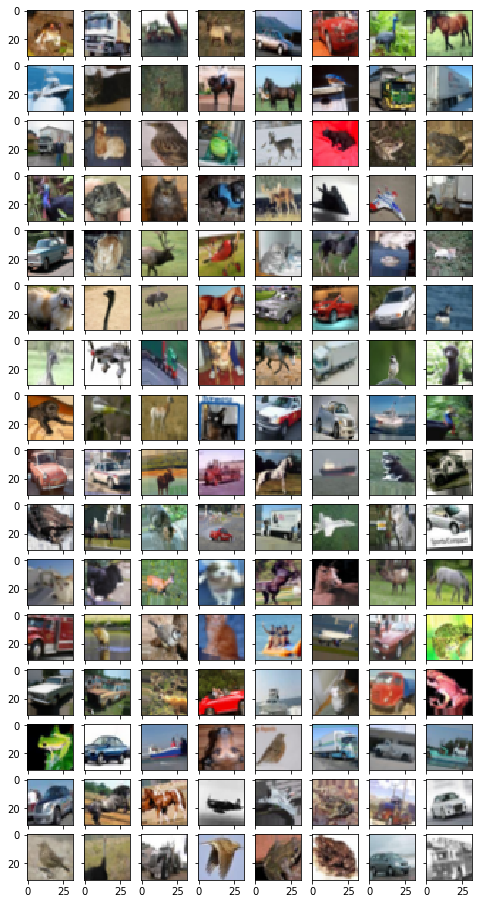

In [0]:
img_combine(_x)

In [0]:
cnn_model = build_CNN(train_x.shape[1:])
sgd = keras.optimizers.SGD(lr = 0.001, momentum = 0.95, nesterov = True)
adam = keras.optimizers.Adam(lr = 0.001)
cnn_model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = adam)
cnn_model.summary()


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_lr = 1e-6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
__________

In [0]:
cifar_aug_gen = make_cifar_aug_gen(data_gen)
batch_size = 128
epochs = 100

In [0]:
history = cnn_model.fit_generator(cifar_aug_gen, steps_per_epoch = train_x.shape[0] // batch_size,
                                  epochs = epochs, validation_data = (test_x, test_y), callbacks = [reduce_lr] )

Epoch 1/100
390/390 [==============================] - 29s 74ms/step - loss: 1.6382 - acc: 0.4076 - val_loss: 1.4795 - val_acc: 0.4818
Epoch 2/100
390/390 [==============================] - 26s 66ms/step - loss: 1.2453 - acc: 0.5528 - val_loss: 1.2815 - val_acc: 0.5588
Epoch 3/100
390/390 [==============================] - 26s 66ms/step - loss: 1.0800 - acc: 0.6172 - val_loss: 0.9397 - val_acc: 0.6666
Epoch 4/100
390/390 [==============================] - 26s 66ms/step - loss: 0.9796 - acc: 0.6543 - val_loss: 0.9991 - val_acc: 0.6640
Epoch 5/100
390/390 [==============================] - 25s 65ms/step - loss: 0.9077 - acc: 0.6808 - val_loss: 0.8950 - val_acc: 0.6885
Epoch 6/100
390/390 [==============================] - 26s 66ms/step - loss: 0.8623 - acc: 0.6961 - val_loss: 0.7948 - val_acc: 0.7208
Epoch 7/100
390/390 [==============================] - 26s 66ms/step - loss: 0.8220 - acc: 0.7128 - val_loss: 1.0543 - val_acc: 0.6569
Epoch 8/100
390/390 [==============================] - 

10000/10000 [==============================] - 1s 129us/step
cnn loss : 0.5001914716601372
cnn acc : 0.8484


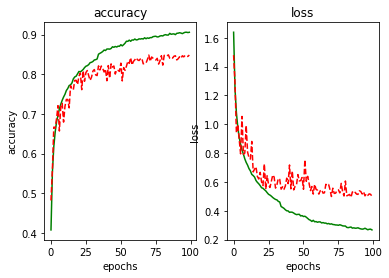

In [0]:
score = cnn_model.evaluate(test_x,test_y)
print(f'cnn loss : {score[0]}')
print(f'cnn acc : {score[1]}')

plt.subplot(1,2,1)
plt.plot(history.history['acc'], '-', label = 'train_acc', color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid_acc', color = 'r')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'g')
plt.plot(history.history['val_loss'],'--', label = 'valid_loss', color = 'r')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()